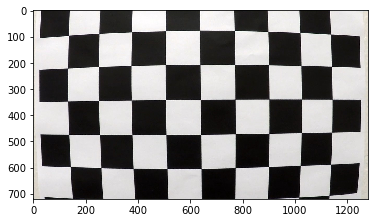

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

False True True True True True True True True True True True True True False False True True True True 

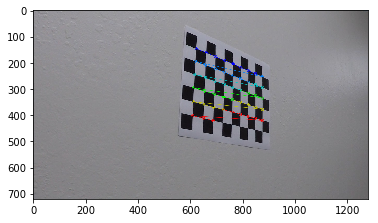

In [2]:
import glob
#%matplotlib qt

# Read in and make list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Arrays to store object points and image points from all the images

objpoints = [] #3D points
imgpoints = [] #2D points

# Prepare object points like (0,0,0),...(7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x,y coordinates

for fname in images:
    img = mpimg.imread(fname)

    # Convert image to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    #plt.imshow(gray)
    print(ret,end=' ')

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

As we can see, not all images were able to fit for calibration, still 17 images were able to calibrate

### Testing Calibration

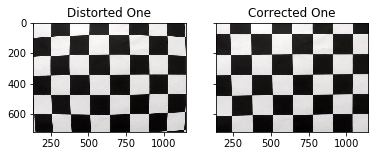

In [14]:
distorted_img = mpimg.imread('./camera_cal/calibration1.jpg')
corrected_img = cv2.undistort(distorted_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (6,2))
ax1.imshow(distorted_img)
ax1.set_title('Distorted One')
ax2.imshow(corrected_img)
ax2.set_title('Corrected One')

Doesn't seems too much corrected.. but still better. Lets try on actual images for lanes


In [4]:
#testing on lanes
lane_distorted_img = cv2.imread('./test_images/straight_lines1.jpg')
lane_corrected_img = cv2.cvtColor(cv2.undistort(lane_distorted_img, mtx, dist, None, mtx), cv2.COLOR_RGB2BGR)


input_vertices = np.float32([[520,500],[770, 500],[250, 680], [1050, 680]])
output_vertices = np.float32([[400,450],[940,450],[400, 700], [940,700]])

persp = cv2.getPerspectiveTransform(input_vertices, output_vertices)
perspRev = cv2.getPerspectiveTransform( output_vertices, input_vertices)
warped = cv2.warpPerspective(lane_corrected_img, persp, (lane_corrected_img.shape[1], lane_corrected_img.shape[0]), flags=cv2.INTER_LINEAR)

Displaying the corrected image

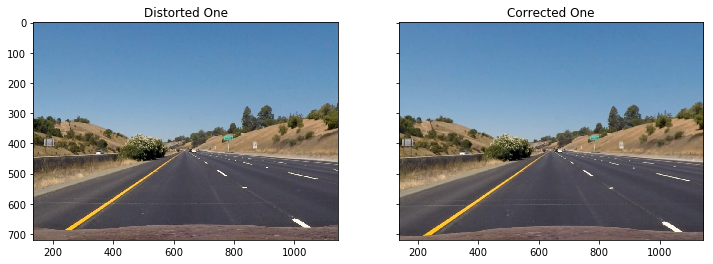

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,4))
ax1.imshow(cv2.cvtColor(lane_distorted_img, cv2.COLOR_RGB2BGR))
ax1.set_title('Distorted One')
ax2.imshow(lane_corrected_img)
ax2.set_title('Corrected One')

**Perspective Transformation**

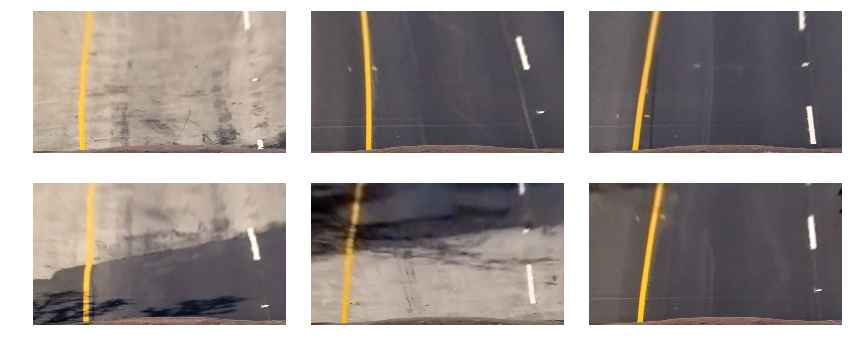

In [6]:
class PerspTransform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))
    

    
imgSnippetSrc = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
imgSnippetDest = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])

bird_view_transformer = PerspTransform(imgSnippetSrc, imgSnippetDest)
    
fig, axes = plt.subplots(2, 3, figsize=(12, 5))
for i in range(2):
    for j in range(3):
        image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
        undist_img = cv2.undistort(image, mtx, dist, None, mtx)
        bird_view = bird_view_transformer.transform(undist_img)
        axes[i, j].imshow(bird_view)
fig.tight_layout()
[ax.axis('off') for axe in axes for ax in axe]
fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

Defining some reusable functions

In [7]:
def get_component_gradient_mask(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    abs_sobel_x, abs_sobel_y = np.absolute(sobelx), np.absolute(sobely)
    #Convert the absolute value image to [0,1]:
    scaled_abs_sobel_x, scaled_abs_sobel_y = abs_sobel_x / np.max(abs_sobel_x), abs_sobel_y / np.max(abs_sobel_y)
    thresh_min_x, thresh_max_x, thresh_min_y, thresh_max_y = 0.1, 1.00, 0.35, 1.00
    sbinary = np.zeros_like(scaled_abs_sobel_x)
    sbinary[((scaled_abs_sobel_x >= thresh_min_x) & (scaled_abs_sobel_x <= thresh_max_x) == 1) & ((scaled_abs_sobel_y >= thresh_min_y) & (scaled_abs_sobel_y <= thresh_max_y) == 1)] = 1
    return sbinary

def get_magnitude_gradient_mask(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    #Convert the absolute value image to [0,1]:
    scaled_abs_sobel = abs_sobel / np.max(abs_sobel)
    thresh_min, thresh_max = 0.5, 1.00 
    sbinary = np.zeros_like(scaled_abs_sobel)
    sbinary[(scaled_abs_sobel >= thresh_min) & (scaled_abs_sobel <= thresh_max)] = 1
    return sbinary

def get_direction_gradient_mask(image, kernel_size=3, threshold=(0.7, 1.2)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    dir_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 
    binary_output =  np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= threshold[0]) & (dir_sobel <= threshold[1])] = 1
    return binary_output

def hsv_color_select(frame):
    # converts image to HSV to ease empirical selection 
    #  of color ranges for maskings
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
     
    lower_yellow = np.array([95,75,100], dtype=np.uint8)
    upper_yellow = np.array([105,255,255], dtype=np.uint8)

    lower_white = np.array([0,0,230], dtype=np.uint8)
    upper_white = np.array([180,35,255], dtype=np.uint8)

    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    color_select = cv2.bitwise_and(frame, frame, mask=mask)
    return mask, color_select

def region_of_interest(image, vertices=None):
    ysize = image.shape[0]
    xsize = image.shape[1]
        
    bottom_left = np.array([0+(.10*xsize), ysize])
    bottom_right = np.array([xsize-(.10*xsize), ysize])
    apex = np.array([xsize/2, ysize*(5/10)])
    vertices = np.array([[bottom_left, bottom_right, apex]])
  
    
    mask = np.zeros_like(image)   
    
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, np.int32(vertices), ignore_mask_color)
    
    masked_image = cv2.bitwise_and(image, mask)
    
    return masked_image

Chaning the image and testing the gradient

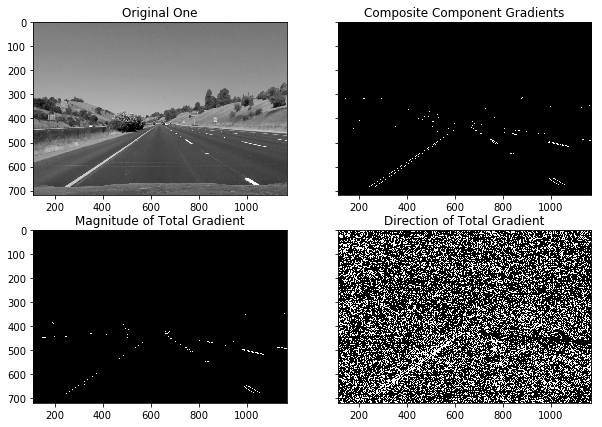

In [8]:
test_image = cv2.cvtColor(lane_distorted_img, cv2.COLOR_BGR2GRAY)
comp = get_component_gradient_mask(test_image)
mag_image = get_magnitude_gradient_mask(test_image)
dir_image = get_direction_gradient_mask(test_image)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize = (10,7))
ax1.imshow(test_image, cmap='gray')
ax1.set_title('Original One')
ax2.imshow(comp, cmap='gray')
ax2.set_title('Composite Component Gradients')
ax3.imshow(mag_image, cmap='gray')
ax3.set_title('Magnitude of Total Gradient')
ax4.imshow(dir_image, cmap='gray')
ax4.set_title('Direction of Total Gradient')

Finding lane by chaning the transformation to HSV to detect yellow line, as yello become more appleaing in HSV transformation

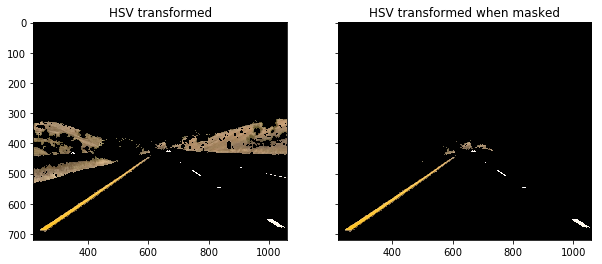

In [9]:
test_image = cv2.cvtColor(lane_distorted_img, cv2.COLOR_RGB2BGR)
mask, hsv = hsv_color_select(test_image)
hsv_mask = region_of_interest(hsv)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,4))
ax1.imshow(hsv)
ax1.set_title('HSV transformed')
ax2.imshow(hsv_mask)
ax2.set_title('HSV transformed when masked')

In masked image, the lane line is completely visible

In [10]:
def compute_poly_2(coefficients, x):
    y = coefficients[0]*x**2 + coefficients[1]*x + coefficients[2]
    return y

def yield_poly_fit_lines(warped):
    # Slightly modified Udacity implementation of histogramimg pixels, plotting polynomials, and returning curvature
    histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base, rightx_base = np.argmax(histogram[:midpoint]), np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(warped.shape[0]/nwindows)
    nonzero = warped.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])

    leftx_current, rightx_current = leftx_base, rightx_base

    margin = 100
    minpix = 50
    
    left_lane_inds, right_lane_inds = [], []

    histo_image = np.dstack((warped, warped, warped))*255

    for window in range(nwindows):
        win_y_low, win_y_high = warped.shape[0] - (window+1)*window_height, warped.shape[0] - window*window_height
        win_xleft_low, win_xleft_high = leftx_current - margin, leftx_current + margin
        win_xright_low, win_xright_high = rightx_current - margin, rightx_current + margin
        cv2.rectangle(histo_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(histo_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds, right_lane_inds = np.concatenate(left_lane_inds), np.concatenate(right_lane_inds)

    leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds]
    rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]
    left_fit, right_fit = np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2)
        
    y_eval = warped.shape[0]
    ym_per_pix, xm_per_pix = 30/720, 3.7/700 
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_center = warped.shape[1]/2.
    test_pt = warped.shape[0] 
    car_deviation = xm_per_pix * np.absolute(car_center - ((compute_poly_2(right_fit, test_pt) + compute_poly_2(left_fit, test_pt)) / 2))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    histo_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    histo_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (left_fit, right_fit), (left_curverad, right_curverad), car_deviation, histo_image

def draw_lanes_to_image(warped, original, left_fit, right_fit, left_curve, right_curve, car_deviation):
    # slightly modified Udacity implementation for line drawing, modified to add curvature
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(warped)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (128,0, 128))#color
    newwarp = cv2.warpPerspective(color_warp, perspRev, (warped.shape[1], warped.shape[0])) 
    
    result_image = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    message = """ Curve: {}""".format((left_curve + right_curve) / 2)
    cv2.putText(result_image, message, (50,100), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    
    message = """ Deviation: {}""".format(car_deviation)
    cv2.putText(result_image, message, (50,60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return result_image

Checking fitting

/Users/sunilp/anaconda3/envs/term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

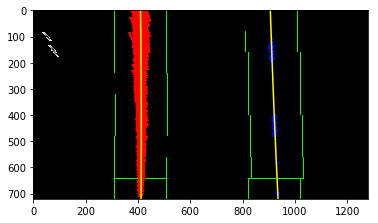

In [11]:
corrected_bgr_image = cv2.undistort(cv2.cvtColor(lane_distorted_img, cv2.COLOR_RGB2BGR), mtx, dist, None, mtx)
hsv_mask, hsv_selected = hsv_color_select(corrected_bgr_image)
hsv_final = region_of_interest(hsv_mask)
warped = cv2.warpPerspective(hsv_final, persp, (hsv_final.shape[1], hsv_final.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap='gray')
(left_fit, right_fit), (left_curverad, right_curverad), dev, histo_image = yield_poly_fit_lines(warped)
out_img = np.dstack((warped, warped, warped))*255
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(histo_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
class Pipeline():
    def __init__(self):
        self.car_deviation = 0
        self.left_curverad = 0
        self.right_curverad = 0
        
    def process_frame(self, image):
        alpha = 0.15
        # Images require conversion, video doesn't
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        corrected_bgr_image = cv2.undistort(image, mtx, dist, None, mtx)

        # corrected_gray_image = cv2.cvtColor(distorted_image, cv2.COLOR_RGB2GRAY)
        # gray_test_lanes_img = gauss_img
        # gauss_img = cv2.GaussianBlur(gray_test_lanes_img, (3,3), 0)


        hsv_mask, hsv_selected = hsv_color_select(corrected_bgr_image)

        hsv_final = region_of_interest(hsv_mask)

        warped = cv2.warpPerspective(hsv_final, persp, (hsv_final.shape[1], hsv_final.shape[0]), flags=cv2.INTER_LINEAR)
    
        (left_fit, right_fit), (left_curverad, right_curverad), car_deviation, histoimage = yield_poly_fit_lines(warped)
        
        self.left_curverad = alpha*left_curverad + (1-alpha)*self.left_curverad
        self.right_curverad = alpha*right_curverad + (1-alpha)*self.right_curverad
        self.car_deviation = alpha*car_deviation + (1-alpha)*self.car_deviation
        
        warped = draw_lanes_to_image(warped, corrected_bgr_image, left_fit, right_fit, self.left_curverad, self.right_curverad, self.car_deviation)
        final = warped
        return warped

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline = Pipeline()
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(pipeline.process_frame) 
%time output_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:51<00:00, 12.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 9s, sys: 8.75 s, total: 2min 17s
Wall time: 1min 52s


In [19]:
#pipeline = Pipeline()
#project_output_2 = 'challenge_video_output.mp4'
#clip2 = VideoFileClip("./challenge_video.mp4")
#output_clip_2 = clip2.fl_image(pipeline.process_frame) 
#%time output_clip_2.write_videofile(project_output_2, audio=False)